In [1]:
# make sure that this is the expected virtual env
!which python

/Users/awlego/Repositories/lc0/env3.10/bin/python


## Setup

Installed Leela Chess Zero for my system. I was unable to get it working in a timely manner on Colab.

In [2]:
# /opt/homebrew/bin/lc0
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install gzip
!pip install tf2onnx
!pip install onnx
!pip install onnxruntime
!pip install matplotlib
!pip install python-chess
!pip install tqdm
!pip install nimfa
!pip install cairosvg
!pip install Pillow


[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement gzip (from versions: none)
ERROR: No matching distribution found for gzip

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

In [24]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.decomposition import NMF
import gzip
import onnx
from lczero.backends import Weights, Backend, GameState
import matplotlib.pyplot as plt
import random
import chess
import chess.svg
import onnxruntime as ort
from tqdm import tnrange, tqdm_notebook
import tqdm
from collections import OrderedDict
import pickle
import scipy
from PIL import Image
import cairosvg
import io
import os


## chess model paths

In [4]:
Lc0_model_path = "/opt/homebrew/Cellar/lc0/0.30.0/libexec/42850.pb.gz"
onnx_path = "/opt/homebrew/Cellar/lc0/0.30.0/libexec/42850.onnx"

I converted the Lc0 model to onnx so that I can load the model and treat mid-model layers as outputs.

## Testing loading the model and getting something out of it

In [5]:
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
sess_options = ort.SessionOptions()
sess = ort.InferenceSession(onnx_path, sess_options)
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# Here's a dummy input for demonstration.
dummy_input_data = np.random.randn(1, 112, 8, 8).astype(np.float32)
print(dummy_input_data.shape)

predictions = sess.run([output_name], {input_name: dummy_input_data})
print(predictions)

(1, 112, 8, 8)
[array([[-4283.983 , -4493.1904,  1841.2926, ..., -2408.3523, -4476.1304,
        -2617.7275]], dtype=float32)]


okay I can look at my onnx model in netron.app and see it looks right -- I see 15 blocks.

## Test Lc0 model

In [6]:
new_board_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
e4e5_board_fen = "rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2"

w = Weights(Lc0_model_path)
b = Backend(weights=w)
g = GameState(new_board_fen)
print(g.as_string())
g2 = GameState(e4e5_board_fen)
print(g2.as_string())

rnbqkbnr
pppppppp
........
........
........
........
PPPPPPPP
RNBQKBNR KQkq[AHah] (from white's eyes) Hash: 2326312736498822375

rnbqkbnr
pppp.ppp
........
....p...
....P...
........
PPPP.PPP
RNBQKBNR KQkq[AHah] (from white's eyes) Hash: 8572518730975593504



Creating backend [metal]...
Initialized metal backend on device Apple M1 Max


Great, looks like I can get a model loaded with the lc0 backend

## Plan & Time Tracking: 
 - [x] pick project \
Running Time Total = pre-work
 - [x] read the Chess Knowledge Paper
 - [x] install Lc0, pick an appropriate model \
Running Time Total = 0 hours (starting timer)
 - [x] encode a board state from a FEN into the format the the model takes \
Running Time Total = 6 hours
 - [x] write something to translate the output into top 3 moves
 - [x] run the model on a new game and an e4e5 game to validate that the predictions match the chess engine version I have \
Running Time Total = 7 hours
 - [x] do the nmf stuff \
Running Time Total = 13 hours
 - [x] visualize the output \
Running Time Total = 21 hours
 - [x] find a way to publish output \
Running Time Total = 25 hours

## Encoding board state from FEN -> format model takes

In [7]:
def print_binary_as_8x8(number):
    # Convert the number to a binary string, removing the '0b' prefix, and pad with leading zeros
    binary_string = format(number, '064b')
    # Split the binary string into 8-character chunks
    rows = [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]
    # flip the bits in the row because the first bit the bottom left not bottom right
    rows = [row[::-1] for row in rows]
    # Print each row to form the 8x8 grid
    for row in rows:
        print(' '.join(row))

print("This should be our pawns")
print_binary_as_8x8(g2.as_input(b).mask(0))
print("This should be our knights")
print_binary_as_8x8(g2.as_input(b).mask(1))

This should be our pawns
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 1 0 0 0
0 0 0 0 0 0 0 0
1 1 1 1 0 1 1 1
0 0 0 0 0 0 0 0
This should be our knights
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 1 0 0 0 0 1 0


okay, so now I need to figure out how to shape this into the shape of the input from my model...

Looking at encoder.cc, weights.h, and bitboard.h in the LC0 source code:
According to Leela there are 112 layers with 8x8 masks (this matches netron's claim of 112x8x8).

looks like they incode various info into a bunch of planes with masks... stuff like which pieces, castling info, etc
relevant snippits:
```
InputPlanes EncodePositionForNN(
    pblczero::NetworkFormat::InputFormat input_format,
    const PositionHistory& history, int history_planes,
    FillEmptyHistory fill_empty_history, int* transform_out) {
  InputPlanes result(kAuxPlaneBase + 8);
```
```
// Represents a board as an array of 64 bits.
// Bit enumeration goes from bottom to top, from left to right:
// Square a1 is bit 0, square a8 is bit 7, square b1 is bit 8.
class BitBoard {
 public:
```

In [8]:
def mask_to_plane(mask):
    # Convert to binary string, strip off the '0b' prefix, and pad to 64 bits
    binary_string = bin(mask)[2:].zfill(64)
    rows = [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]
    rows = [row[::-1] for row in rows]
    rows.reverse()

    plane = np.array([[float(bit) for bit in row] for row in rows])
    return plane

def game_state_to_input_data(game_state, backend):
    # Create an empty array of shape (112, 8, 8)
    board_planes = np.zeros((112, 8, 8), dtype=np.float32)

    for i in range(112):
        board_planes[i] = mask_to_plane(game_state.as_input(backend).mask(i))
    # Add a batch dimension
    input_data = board_planes[np.newaxis, :]

    return input_data

input_data = game_state_to_input_data(g2, b)
input_data[0][0]

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
predictions = sess.run([output_name], {input_name: input_data})
print(len(predictions[0][0]))
# 1858 is the the /output/policy shape (batch x 1858) as seen in netron.app
print(np.argsort(predictions[0].flatten())[::-1])

1858
[1348 1286 1218 ... 1445 1532 1417]


Wooo looks like I can get some predicitons out from my input!

Now do these mean anything....?

## write something to translate the output into top 3 moves

In [10]:
def p_softmax(indicies, p_, p_raw_func):
    """
    Convert raw logits to softmax probabilities.

    Args:
        indicies (list[int]): List of indices to consider.
        p_raw_func (callable): A function that accepts a list of indices and returns the corresponding raw logits.

    Returns:
        list[float]: Softmax probabilities.
    """
    # Get raw logits for the provided indices
    p_vals = np.array(p_raw_func(indicies, p_))
    
    # Calculate the maximum value for numerical stability
    max_p = np.max(p_vals)
    
    # Calculate exponential values
    p_vals = np.exp(p_vals - max_p)
    
    # Normalize to get probabilities
    total = np.sum(p_vals)
    if total > 0:
        p_vals /= total
    
    return p_vals.tolist()

def p_raw(indicies, p_):
    """
    Extract raw logits from the provided p_ array based on given indices.

    Args:
        indicies (list[int]): List of indices to consider.
        p_ (list[float]): Array containing raw logits or scores.

    Returns:
        list[float]: Extracted raw logits or scores.
    """
    if any(idx < 0 or idx > 1857 for idx in indicies):
        raise ValueError("Policy index must be between 0 and 1857.")
    
    return [p_[idx] for idx in indicies]
    
# predictions at 0 since our predictions are batched and we have a batch of 1 here
list(zip(g2.moves(), p_softmax(g2.policy_indices(), predictions[0].flatten(), p_raw)))

[('b1a3', 0.00176935363560915),
 ('b1c3', 0.17127680778503418),
 ('d1e2', 0.0018413171637803316),
 ('d1f3', 0.002226013457402587),
 ('d1g4', 0.0018571442924439907),
 ('d1h5', 0.0020254654809832573),
 ('e1e2', 0.0014671743847429752),
 ('f1e2', 0.01257892046123743),
 ('f1d3', 0.004621283616870642),
 ('f1c4', 0.04742936044931412),
 ('f1b5', 0.003494646167382598),
 ('f1a6', 0.0016979064093902707),
 ('g1e2', 0.004234056454151869),
 ('g1f3', 0.6688069701194763),
 ('g1h3', 0.0018182129133492708),
 ('a2a3', 0.010685446672141552),
 ('a2a4', 0.006090154405683279),
 ('b2b3', 0.0021589896641671658),
 ('b2b4', 0.001737439539283514),
 ('c2c3', 0.004193421453237534),
 ('c2c4', 0.0030142730101943016),
 ('d2d3', 0.013650806620717049),
 ('d2d4', 0.011918947100639343),
 ('f2f3', 0.0018552218098193407),
 ('f2f4', 0.0021102826576679945),
 ('g2g3', 0.0027578608132898808),
 ('g2g4', 0.001521746045909822),
 ('h2h3', 0.009272726252675056),
 ('h2h4', 0.0018878747941926122)]

Great! These look reasonable.

### Let's calculate the true Lc0 output so I can validate that my representations are working correctly

In [11]:
dummy_input = GameState(e4e5_board_fen).as_input(b)
input = g2.as_input(b)
output, _ = b.evaluate(input, dummy_input)
list(zip(g2.moves(), output.p_softmax(*g2.policy_indices())))

[('b1a3', 0.0017741298070177436),
 ('b1c3', 0.17404316365718842),
 ('d1e2', 0.001867432612925768),
 ('d1f3', 0.002248866017907858),
 ('d1g4', 0.0018720037769526243),
 ('d1h5', 0.0020443403627723455),
 ('e1e2', 0.0014642218593508005),
 ('f1e2', 0.01243040431290865),
 ('f1d3', 0.004636666271835566),
 ('f1c4', 0.04721570760011673),
 ('f1b5', 0.003496352816000581),
 ('f1a6', 0.0017000455409288406),
 ('g1e2', 0.004145870916545391),
 ('g1f3', 0.6667669415473938),
 ('g1h3', 0.0018152031116187572),
 ('a2a3', 0.010607978329062462),
 ('a2a4', 0.006029128096997738),
 ('b2b3', 0.0021638551261276007),
 ('b2b4', 0.0017414273461326957),
 ('c2c3', 0.004176905378699303),
 ('c2c4', 0.003008705098181963),
 ('d2d3', 0.013671309687197208),
 ('d2d4', 0.011745461262762547),
 ('f2f3', 0.0018560135504230857),
 ('f2f4', 0.002120622666552663),
 ('g2g3', 0.0027426090091466904),
 ('g2g4', 0.001520868157967925),
 ('h2h3', 0.009203264489769936),
 ('h2h4', 0.0018903155578300357)]

Great! These match!

# NMF Stuff

## Extracting Layers from the model so I can compute the outputs per layer as per the deepmind paper

In [12]:
def onnx_layer_output(onnx_path, dummy_input):
    ort_session = ort.InferenceSession(onnx_path)
    org_outputs = [x.name for x in ort_session.get_outputs()]
    model = onnx.load(onnx_path)
    for node in model.graph.node:
        for output in node.output:
            if output not in org_outputs:
                model.graph.output.extend([onnx.ValueInfoProto(name=output)])
    # excute onnx
    ort_session = ort.InferenceSession(model.SerializeToString())
    outputs = [x.name for x in ort_session.get_outputs()]
    ort_inputs = {ort_session.get_inputs()[0].name: dummy_input}
    ort_outs = ort_session.run(outputs, ort_inputs)
    ort_outs = OrderedDict(zip(outputs, ort_outs))
    return ort_outs

input_data = game_state_to_input_data(g2, b)
model_outputs = onnx_layer_output(onnx_path, input_data)
for key in model_outputs.keys():
    print(key, model_outputs[key].shape)

/output/policy (1, 1858)
/output/wdl (1, 3)
/output/mlh (1, 1)
/inputconv (1, 192, 8, 8)
/inputconv/relu (1, 192, 8, 8)
/block0/conv1 (1, 192, 8, 8)
/block0/conv1/relu (1, 192, 8, 8)
/block0/conv2 (1, 192, 8, 8)
/block0/conv2/se/pooled (1, 192, 1, 1)
/block0/conv2/se/squeeze (1, 192)
/block0/conv2/se/matmul1 (1, 32)
/block0/conv2/se/add1 (1, 32)
/block0/conv2/se/relu (1, 32)
/block0/conv2/se/matmul2 (1, 384)
/block0/conv2/se/add2 (1, 384)
/block0/conv2/se/reshape (1, 384, 1, 1)
/block0/conv2/se/split/out1 (1, 192, 1, 1)
/block0/conv2/se/split/out2 (1, 192, 1, 1)
/block0/conv2/se/sigmoid (1, 192, 1, 1)
/block0/conv2/se/mul (1, 192, 8, 8)
/block0/conv2/se/add3 (1, 192, 8, 8)
/block0/conv2/mixin (1, 192, 8, 8)
/block0/conv2/relu (1, 192, 8, 8)
/block1/conv1 (1, 192, 8, 8)
/block1/conv1/relu (1, 192, 8, 8)
/block1/conv2 (1, 192, 8, 8)
/block1/conv2/se/pooled (1, 192, 1, 1)
/block1/conv2/se/squeeze (1, 192)
/block1/conv2/se/matmul1 (1, 32)
/block1/conv2/se/add1 (1, 32)
/block1/conv2/se/relu

In [13]:
mixin = model_outputs[f'/block0/conv2/mixin']

## Generate FENs from which I can get lots of games to check the activations of the model

In [14]:
NEW_BOARD_FEN = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
GAME_OVER_FEN = "8/1K6/4k3/8/8/8/8/8 b - - 100 500"
ALMOST_OVER_FEN = "rn2kbnr/ppp2ppp/8/3pp3/2BPP3/2PK4/PP3qPP/RNBb2NR b kq - 0 8"

class ChessGame():
    
    def __init__(self):
        self.w = Weights(Lc0_model_path)
        self.b = Backend(weights=w)
        self.g = GameState(NEW_BOARD_FEN)
        self.moves = []
        self.fens = set()
        self.setup_model()
        self.chess_board = chess.Board(NEW_BOARD_FEN)
        self.game_over = False

    def setup_model(self):
        session_options = ort.SessionOptions()
        self.session = ort.InferenceSession(onnx_path, session_options)
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name

    def pick_random_weighted_move(self, weighted_options):
        # assumes the weights are already normalized
        # Create the cumulative distribution
        cumulative_distribution = []
        cumulative_sum = 0
        for option, weight in weighted_options:
            cumulative_sum += weight
            cumulative_distribution.append((option, cumulative_sum))

        # Randomly select
        r = random.random()
        for option, cumulative_weight in cumulative_distribution:
            if r <= cumulative_weight:
                # print(f"Randomly selected option: {option}")
                return option
            
    def log_fen(self, fen):
        self.fens.add(fen)
            
    def make_move(self, move):
        self.moves.append(move)
        self.g = GameState(moves=self.moves)

        move_obj = self.chess_board.parse_san(move)
        self.chess_board.push(move_obj)
        self.log_fen(self.chess_board.fen())

    def take_turn(self):
        input_data = game_state_to_input_data(self.g, self.b)
        predictions = self.session.run([self.output_name], {self.input_name: input_data})
        move_choices = list(zip(self.g.moves(), p_softmax(self.g.policy_indices(), predictions[0].flatten(), p_raw)))
        # print(move_choices)
        # print(sorted(move_choices, key=lambda x: x[1]))
        move = self.pick_random_weighted_move(move_choices)
        self.make_move(move)

    def check_game_over(self):
        if any([
            self.chess_board.is_checkmate(),
            self.chess_board.is_stalemate(),
            self.chess_board.outcome(),
            self.chess_board.can_claim_draw(),
            self.chess_board.can_claim_threefold_repetition(),
            self.chess_board.can_claim_fifty_moves(),
            self.chess_board.is_insufficient_material(),
            self.chess_board.is_fivefold_repetition(),
            self.chess_board.is_seventyfive_moves(),
        ]):
            self.game_over = True
            return True
        else:
            return False

    def play_game(self):
        for i in range(100):
            if not self.check_game_over():
                self.take_turn()
            else:
                return self.fens, self.game_over
        return self.fens, self.game_over

In [15]:
def generate_fens():
    chess_game = ChessGame()
    fens = set()
    while len(fens) < 10000:
        game_fens, game_over = chess_game.play_game()
        fens.update(game_fens)
        if game_over:
            chess_game = ChessGame()
        print(len(fens))
    return fens

def save_fens(fens):
    with open('fens.txt', 'w') as f:
        # add a test game that I want to try
        f.write("r1bqrnk1/pp1p1ppp/2p5/8/3Bp3/6P1/PPP1PPBP/R2QR1K1 b - - 8 27\n")
        # and continue with the rest of 'em
        for fen in fens:
            f.write(f"{fen}\n")

def load_fens(filename='fens.txt'):
    with open(filename, 'r') as f:
        fens = f.readlines()
    return fens
#change to 1 to generate fens again    
if 0:
    fens = generate_fens()
    save_fens(fens)
else:
    fens = load_fens()

In [16]:
print(fens[0])
print(len(fens))

r1bqrnk1/pp1p1ppp/2p5/8/3Bp3/6P1/PPP1PPBP/R2QR1K1 b - - 8 27

10032


## Let's test NMF and see if I understand how the library implementation works on a dummy matrix

In [17]:
import numpy as np
X = np.random.randint(low=0, high=10, size=(8, 8))
from sklearn.decomposition import NMF
model = NMF(n_components=36, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [18]:
print(H.shape, W.shape, X)

(36, 8) (8, 36) [[5 4 8 8 6 0 3 9]
 [1 2 7 0 3 2 8 3]
 [0 9 2 3 6 1 9 7]
 [3 4 9 2 7 5 8 0]
 [8 6 6 5 8 1 4 6]
 [7 6 4 7 8 4 6 3]
 [7 7 4 2 8 7 7 1]
 [6 0 7 0 5 0 3 4]]


In [19]:
np.matmul(W, H)

array([[4.99999906e+00, 4.00002775e+00, 8.00005224e+00, 8.00000247e+00,
        5.99998961e+00, 7.69587425e-03, 3.00000053e+00, 8.99999935e+00],
       [1.00006076e+00, 1.99969463e+00, 6.99995109e+00, 3.60060940e-04,
        3.00006958e+00, 1.99919282e+00, 8.00000211e+00, 3.00001521e+00],
       [9.48265497e-04, 9.00006356e+00, 1.99996824e+00, 2.99999802e+00,
        5.99999698e+00, 9.99794669e-01, 8.99999240e+00, 6.99999893e+00],
       [3.00001822e+00, 3.99992373e+00, 8.99997290e+00, 1.99999723e+00,
        6.99999774e+00, 4.99965296e+00, 7.99999567e+00, 8.16635334e-04],
       [7.99999454e+00, 5.99965695e+00, 5.99993797e+00, 4.99999198e+00,
        8.00000752e+00, 9.99865143e-01, 4.00008278e+00, 6.00001057e+00],
       [7.00001355e+00, 6.00047434e+00, 4.00008091e+00, 7.00000934e+00,
        8.00001370e+00, 4.00116189e+00, 5.99999820e+00, 2.99999367e+00],
       [6.99996931e+00, 7.00005885e+00, 4.00002913e+00, 2.00001340e+00,
        8.00000087e+00, 7.00239121e+00, 6.99999973e+00, 1.

Okay it looks like it's approximating our thing pretty well. As I increase the number of components the accuracy goes up.

## Let's do actual NMF on our model/data

In [20]:

def get_activations(fen, num_layers):
    '''gets all layer activations for a given fen'''
    game_state = GameState(fen)
    input_data = game_state_to_input_data(game_state, b)

    model_outputs = onnx_layer_output(onnx_path, input_data)
    Z_hat_l = {}
    for l in range (num_layers):
        Z_hat_l[l] = model_outputs[f'/block{l}/conv2/relu']
    return Z_hat_l

In [21]:
# Define dimensions
H, W, C = 8, 8, 192  # Height, Width, Channels
K = 36  # Number of NMF components
L = 15  # Number of layers
N = len(fens)  # Number of instances

In [22]:
# load all the activations for all the boards
Z_hat_ls = {}

# this code take a long time to run, fyi
for fen in tqdm_notebook(fens, desc="fen"):
    Z_hat_l = get_activations(fen, L)

    # go through each layer
    for layer in Z_hat_l:
        z_l_flattened = Z_hat_l[layer].reshape(H*W, C)
        try:
            Z_hat_ls[layer].append(z_l_flattened)
        except KeyError:
            Z_hat_ls[layer] = []
            Z_hat_ls[layer].append(z_l_flattened)

for layer in Z_hat_ls:
    Z_hat_ls[layer] = np.vstack(Z_hat_ls[layer])
    

/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_60147/767832329.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fen in tqdm_notebook(fens, desc="fen"):


fen:   0%|          | 0/10032 [00:00<?, ?it/s]

# Right about here is the time limit cutoff. If you want to judge based on what I can do in the 10-16 hour range, only count code above. However, I was interested, so I kept going... I hadn't gotten to what I felt was the juicy part of the project yet:

In [25]:
saved_nmf = {}

if scipy.sparse.issparse(Z_hat_ls[0]):
    algo = "nndsvd"
else:
    algo = "nndsvda" # better for sparse matrixes
print(f"Using {algo} as the initialization method.")

for l in tqdm_notebook(range(L), desc="layer"): # should be range(L) for final fun
    # z_matrices = Z_hat_ls[l]
    # Z_hat_l = np.array(z_matrices)  # This will have shape (N, H*W*C)
                                    # this SHOULD have shape (NHW x C)
    
    Z_hat_l = Z_hat_ls[l] # this SHOULD have shape (NHW x C)
    print(Z_hat_l.shape)
    # (642048, 192) is the shape... this seems right

    # Apply NMF to Z_hat_l
    # okay looking up frobenius I'm pretty sure that's the right one
    nmf = NMF(n_components=K, max_iter=2000, init=algo, solver='cd', beta_loss='frobenius')
    nmf_W = nmf.fit_transform(Z_hat_l)  # This will have shape (N, K)
    nmf_H = nmf.components_  # This will have shape (K, C)

    saved_nmf[f"nmf_W_{l}"] = nmf_W
    saved_nmf[f"nmf_H_{l}"] = nmf_H


Using nndsvda as the initialization method.


/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_60147/787839169.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for l in tqdm_notebook(range(L), desc="layer"): # should be range(L) for final fun


layer:   0%|          | 0/15 [00:00<?, ?it/s]

(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)
(642048, 192)


In [26]:
print(nmf.reconstruction_err_) # todo look into this later

2963.963225142984


In [27]:
# Save the dictionary to a file so I don't have to run that big things again
with open('nmf_data.pkl', 'wb') as file:
    pickle.dump(saved_nmf, file)

In [28]:
# Load the dictionary from the file
with open('nmf_data.pkl', 'rb') as file:
    nmf_data_loaded = pickle.load(file)
    saved_nmf = nmf_data_loaded

The shape of nmf_W (which represents the matrix Ω in the paper) should be designed to reflect the structure of the data it's derived from. Since each row in corresponds to a square on the chessboard and each column to one of the K NMF factors, the shape of nmf_W should be:

Number of rows: equal to the number of squares on the chessboard, which is H×W. For an 8x8 chessboard, this would be 8×8=64.
Number of columns: equal to the number of NMF factors K that you have decided to use for dimensionality reduction. So if you have K=32 factors, then nmf_W should be a 64x32 matrix. Each row of this matrix corresponds to one of the 64 squares on the chessboard, and each column corresponds to one of the 32 factors.

In [29]:
print(nmf_W.shape)
print(nmf_H.shape)
print(len(Z_hat_l[0]))
print(Z_hat_l.shape)
z_hat_1 = get_activations(e4e5_board_fen, 1)
print(z_hat_1[0].shape)

(642048, 36)
(36, 192)
192
(642048, 192)
(1, 192, 8, 8)


## Visualization

Let's just get a chess board with colored squares showing first

{35: None, 37: None}


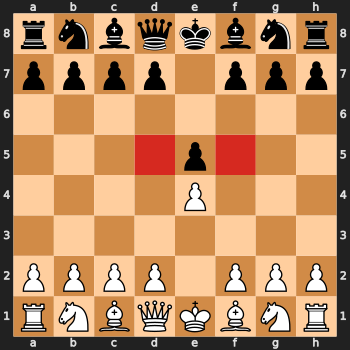

In [30]:
def map_data_to_alpha(grid, color):
    # Flatten the grid to make it easier to work with
    flat_grid = [item for sublist in grid for item in sublist]
    
    # Find the min and max values in the grid
    min_val = min(flat_grid)
    max_val = max(flat_grid)
    
    # Function to normalize and map values to the 0x00-0xFF range
    def normalize(value, min_val, max_val):
        # Avoid division by zero if all values in the grid are the same
        return int(255 * (value - min_val) / (max_val - min_val)) if max_val != min_val else 0
    
    # Create the mapping dictionary
    alpha_mapping = {}
    
    for i, value in enumerate(flat_grid):
        # Normalize the value to get the alpha equivalent
        alpha_hex = format(normalize(value, min_val, max_val), '02X')
        # Map the color and alpha to the dictionary
        alpha_mapping[i] = f'{color}{alpha_hex}'
    
    return alpha_mapping

color = '#056608'  

board = chess.Board(e4e5_board_fen)
board.piece_at(62)

print(dict.fromkeys(board.attacks(chess.E4)))
chess.svg.board(board, size=350, fill=dict.fromkeys(board.attacks(chess.E4), "#cc0000cc"))

so since W = omega_all, I want to visualize that
To visualize the NMF factors for activations zl, we overlay the K columns of Ω∗ onto the input z0. The visualization of factor k’s contributions to zl is done by reshaping the column k of Ω∗ into a H ×W or 8×8 matrix. The visualization shows how much NMF factor k contributes to each neuron’s representation.

## single board / block / factor

Contribution of Factor 1 to Position 3


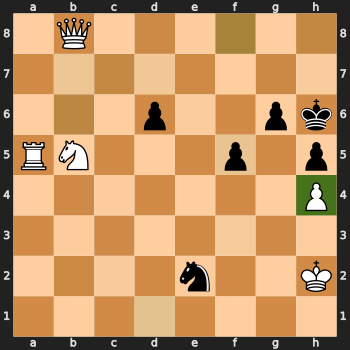

In [31]:
position_index = 2
AlphaZeroExample1_fen= "r1bqrnk1/pp1p1ppp/2p5/8/3Bp3/6P1/PPP1PPBP/R2QR1K1 b - - 8 27"
board = chess.Board(AlphaZeroExample1_fen)
board = chess.Board(fens[position_index])

# choose a layer to visualize:
layer = 0
# Choose a specific factor to visualize
factor_index = 0


nmf_W = saved_nmf[f"nmf_W_{layer}"]
nmf_H = saved_nmf[f"nmf_H_{layer}"]

nmf_W = np.asarray(nmf_W)
nmf_W = nmf_W.reshape(N, H, W, K)

# Get the weight of this factor for the chosen position
factor_weight = nmf_W[position_index, factor_index]

# Visualize the contribution
print(f'Contribution of Factor {factor_index + 1} to Position {position_index + 1}')
alpha_dict = map_data_to_alpha(factor_weight, color)
chess.svg.board(board, size=350, fill=alpha_dict)

## All boards / blocks / factors
Saves them to files as svg. About a gigabyte for 15 blocks * 36 factors * 50 boards. I should probably compress them.

In [32]:
def save_svg_to_file(svg_data, file_path):
    """
    Saves the SVG representation of a chess board to a file.

    :param board: The chess board object.
    :param file_path: The path to the file where the SVG will be saved.
    """
    with open(file_path, 'w') as file:
        file.write(svg_data)

all_svgs = []

for board_index in range(50):
    board = chess.Board(fens[board_index])

    for layer in range(L):
        nmf_W = saved_nmf[f"nmf_W_{layer}"]
        nmf_W = np.asarray(nmf_W)
        nmf_W = nmf_W.reshape(N, H, W, K)

        for factor_index in range(K):
            # Get the weight of this factor for the chosen position
            # board_weights = nmf_W[board_index]
            factor_weight = nmf_W[board_index, :, :, factor_index]

            alpha_dict = map_data_to_alpha(factor_weight, color)
            svg = chess.svg.board(board, size=350, fill=alpha_dict)
            save_svg_to_file(svg, f"nmf_images/board_{board_index}_layer_{layer}_factor{factor_index}.svg")

In [ ]:

def convert_svg_to_webp(svg_path, webp_path, quality=80):
    # Read the SVG file
    with open(svg_path, 'rb') as svg_file:
        svg_data = svg_file.read()
    
    # Convert SVG to PNG using cairosvg
    png_data = cairosvg.svg2png(bytestring=svg_data)
    
    # Convert PNG data to an Image object
    image = Image.open(io.BytesIO(png_data))
    
    # Convert Image object to WebP format and save it
    image.save(webp_path, 'WEBP', quality=quality)
    print(f"Saved WebP image at {webp_path} with quality {quality}.")

def convert_svgs_in_folder(folder_path, output_folder, quality=80):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the given folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".svg"):
            svg_path = os.path.join(folder_path, filename)
            webp_filename = os.path.splitext(filename)[0] + '.webp'
            webp_path = os.path.join(output_folder, webp_filename)

            # Convert the SVG to WebP
            convert_svg_to_webp(svg_path, webp_path, quality)
            print(f"Converted {svg_path} to {webp_path}")

convert_svgs_in_folder('nmf_images', 'nmf_images_compressed')


Saved WebP image at nmf_images_compressed/board_39_layer_12_factor2.webp with quality 80.
Converted nmf_images/board_39_layer_12_factor2.svg to nmf_images_compressed/board_39_layer_12_factor2.webp
Saved WebP image at nmf_images_compressed/board_49_layer_12_factor10.webp with quality 80.
Converted nmf_images/board_49_layer_12_factor10.svg to nmf_images_compressed/board_49_layer_12_factor10.webp
Saved WebP image at nmf_images_compressed/board_1_layer_6_factor34.webp with quality 80.
Converted nmf_images/board_1_layer_6_factor34.svg to nmf_images_compressed/board_1_layer_6_factor34.webp
Saved WebP image at nmf_images_compressed/board_20_layer_14_factor7.webp with quality 80.
Converted nmf_images/board_20_layer_14_factor7.svg to nmf_images_compressed/board_20_layer_14_factor7.webp
Saved WebP image at nmf_images_compressed/board_6_layer_9_factor5.webp with quality 80.
Converted nmf_images/board_6_layer_9_factor5.svg to nmf_images_compressed/board_6_layer_9_factor5.webp
Saved WebP image at n